In [1]:
from datasets import load_dataset
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from spacy.lang.es.stop_words import STOP_WORDS
from wordcloud import WordCloud
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pyLDAvis
import pyLDAvis.lda_model
import spacy

# creo una lista con las stopwords en español
spanish_stop_words = list(STOP_WORDS)

In [2]:
dataset = load_dataset('kevmansilla/jokes_spanish_tm', split='train')
dataset

Dataset({
    features: ['joke'],
    num_rows: 1732
})

In [3]:
def limpiar_etiquetas(ejemplo):
    texto = ejemplo['joke']  # Asumiendo que la columna se llama 'text'
    # Eliminar las etiquetas especificadas
    texto_limpio = (
        texto.replace("<START>", "")
             .replace("[QUESTION]", "")
             .replace("[ANSWER]", "")
             .replace("<END>", "")
             .strip()  # Eliminar espacios extra al inicio y final
    )
    return {'joke': texto_limpio}


# Aplicar la limpieza al dataset
dataset_limpio = dataset.map(limpiar_etiquetas)

# Verificar los cambios
print(dataset_limpio[:5])  # Mostrar las primeras 5 filas

{'joke': ['¿Cuál es el beneficio de salir con una visca?\n - Que mientras te chupa laicha, te cuida la moto. Jaja', '¿Cuál es la diferencia entre Jesucristo y un retrato de Jesucristo?\n Pues el retrato necesita un clavo.', '¿Cuál es la diferencia entre una mujer y dos hombres sin brazos?\n Que ninguno tiene derechos.', 'Hay un nazi que esta por ejecutar a un negro y un judío, ¿a quien mata primero y por que?\n - Mata primero al judío, porque el trabajo es primero y la diversión después', 'Qué es lo más difícil de ocultar en una piscina de bebés muertos?\n - La erección']}


In [4]:
# Crear un DataFrame de pandas
df = pd.DataFrame(dataset_limpio)

In [5]:
df

,joke
0,¿Cuál es el beneficio de salir con una visca?\...
1,¿Cuál es la diferencia entre Jesucristo y un r...
2,¿Cuál es la diferencia entre una mujer y dos h...
3,Hay un nazi que esta por ejecutar a un negro y...
4,Qué es lo más difícil de ocultar en una piscin...
...,...
1727,¿Sabes qué le dice una piedra a otra?\n ¡La vi...
1728,¿Por qué está tan feliz siempre la escoba?\n P...
1729,¿Qué le dice un gusano a otro?\n Me voy a dar ...
1730,¿Cuál es el colmo de una cabra?\n Que los hijo...


## Modelo 1

Un modelo de temas con NMF (Non-negative Matrix Factorization) es una técnica que se utiliza para encontrar temas ocultos en un conjunto de documentos.

¿Cómo funciona en palabras simples?
1. Descomposición de la matriz:
    - Piensa que cada documento es como una bolsa de palabras. El modelo toma todos estos documentos y las palabras que contienen y crea una gran tabla (matriz) donde cada fila es un documento y cada columna es una palabra.
    - Luego, el modelo NMF descompone esta tabla en dos partes más pequeñas:
        - Una parte que nos dice qué palabras están relacionadas con cada tema.
        - Otra parte que nos dice qué temas están presentes en cada documento.
2. Temas ocultos:
    - El modelo NMF encuentra grupos de palabras que tienden a aparecer juntas en los documentos. Cada grupo de palabras representa un tema.
    - Por ejemplo, en un conjunto de noticias, el modelo podría identificar temas como "deportes" con palabras como "equipo", "partido", "jugador", y otro tema sobre "economía" con palabras como "mercado", "dinero", "finanzas".
3. Asignación de temas:
    - Una vez que el modelo ha encontrado los temas, puede decirte qué temas son los más importantes en cada documento. Por ejemplo, puede indicar que un documento trata en un 70% de "deportes" y en un 30% de "economía".


In [6]:
def display_topics(H, feature_names, no_top_words):
    '''
    Display the topics generated by the NMF model (without documents)
    '''
    for topic_idx, topic in enumerate(H):
        print(' ')
        print('Topic %d:' % (topic_idx))
        print(' '.join([(feature_names[i] + ' (' + str(topic[i].round(2)) + ')')
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [7]:
# Defino argumentos
no_topics = 8
no_top_words = 6

# Inicializacion del vectorizador TF-IDF
tfidf_vectorizer = TfidfVectorizer(
    max_df=0.95, min_df=2, stop_words=spanish_stop_words)

# Ajuste y transformación del vectorizador TF-IDF
tfidf = tfidf_vectorizer.fit_transform(df['joke'])

# Obtención de los nombres de las características (palabras):
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

# Ejecución del modelo NMF:
nmf_model = NMF(n_components=no_topics, random_state=1,
                l1_ratio=.5, init='nndsvd').fit(tfidf)

# Obtención de las matrices de temas y documentos
nmf_W = nmf_model.transform(tfidf)
nmf_H = nmf_model.components_

print('NMF Topics')
display_topics(nmf_H, tfidf_feature_names, no_top_words)
print('--------------')

NMF Topics
 
Topic 0:
colmo (1.91) perder (0.24) ciego (0.22) enamorarse (0.18) policía (0.18) colmillo (0.17)
 
Topic 1:
llama (2.25) judío (0.54) lee (0.48) bruce (0.3) broco (0.24) primo (0.21)
 
Topic 2:
diferencia (1.41) bebé (0.89) bolsa (0.27) común (0.24) perro (0.24) semáforo (0.21)
 
Topic 3:
pez (1.85) agua (0.21) espacio (0.11) huele (0.1) mero (0.09) espectador (0.09)
 
Topic 4:
cáncer (1.32) niño (1.01) niños (0.34) común (0.29) jugar (0.2) regalo (0.16)
 
Topic 5:
gimnasio (1.46) asistente (0.54) trajo (0.28) gusta (0.25) favorito (0.25) rata (0.24)
 
Topic 6:
mujer (1.36) hombre (0.55) sexo (0.29) embarazada (0.23) tienes (0.22) oye (0.18)
 
Topic 7:
hijo (1.16) mamá (0.87) hija (0.23) doctor (0.23) papá (0.22) papa (0.17)
--------------


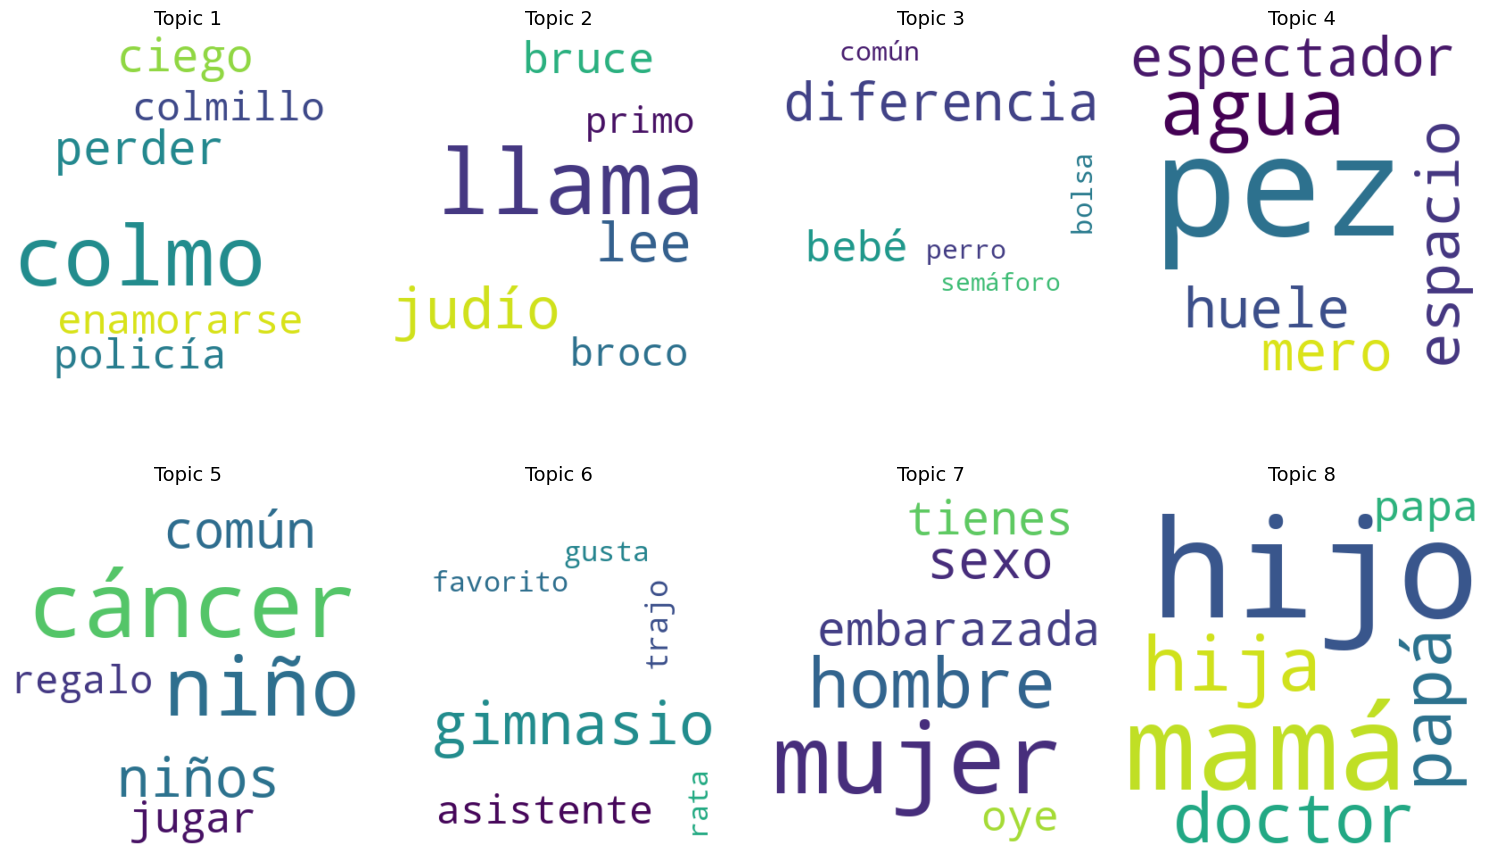

In [8]:
def plot_wordclouds(H, feature_names, no_top_words, no_topics):
    '''
    Generate word clouds for each topic
    '''
    fig, axes = plt.subplots(2, int(np.ceil(no_topics / 2)), figsize=(15, 10))
    axes = axes.flatten()

    for topic_idx, topic in enumerate(H):
        # Obtener las palabras principales y sus pesos
        top_features_ind = topic.argsort()[:-no_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        # Crear un diccionario de palabras y pesos
        word_freq = {top_features[i]: weights[i]
                     for i in range(len(top_features))}

        # Generar la nube de palabras
        wordcloud = WordCloud(
            width=400, height=400, background_color='white').generate_from_frequencies(word_freq)

        # Mostrar la nube en el subplot correspondiente
        axes[topic_idx].imshow(wordcloud, interpolation='bilinear')
        axes[topic_idx].axis('off')
        axes[topic_idx].set_title(f'Topic {topic_idx + 1}', fontsize=14)

    plt.tight_layout()
    plt.show()


# Graficar nubes de palabras para los tópicos
plot_wordclouds(nmf_H, tfidf_feature_names, no_top_words, no_topics)

## LDA

In [24]:
# Usar CountVectorizer en lugar de TfidfVectorizer
count_vectorizer = CountVectorizer(stop_words=spanish_stop_words)

# Transformar los datos textuales
X_counts = count_vectorizer.fit_transform(df['joke'])

# Crear el modelo LDA
number_of_topics = 8
lda = LatentDirichletAllocation(n_components=number_of_topics, random_state=0)

# Ajustar el modelo a los datos
lda.fit(X_counts)

# Preparar la visualización de los tópicos con pyLDAvis
pyLDAvis.enable_notebook()
panel = pyLDAvis.lda_model.prepare(
    lda, X_counts, count_vectorizer, mds='tsne', R=6)

# Mostrar la visualización interactiva
pyLDAvis.display(panel)

In [25]:
# Cargar el modelo de español de spaCy
nlp = spacy.load("es_core_news_sm")

# Función para preprocesar el texto


def preprocess_text(text):
    # Procesar el texto con spaCy
    doc = nlp(text.lower())  # Convertir a minúsculas
    # Lematizar y eliminar puntuaciones
    cleaned_text = " ".join(
        [token.lemma_ for token in doc if not token.is_punct and not token.is_space])
    return cleaned_text


# Aplicar el preprocesamiento a la columna 'joke' de tu DataFrame
df['cleaned_text'] = df['joke'].apply(preprocess_text)

# Crear la lista de stop words en español
spanish_stop_words = list(STOP_WORDS)

# Preprocesamiento de los datos
count_vectorizer = CountVectorizer(
    stop_words=spanish_stop_words,
    min_df=5,
    max_df=0.8,
    ngram_range=(1, 2)  # Captura unigramas y bigramas
)

# Transformar los datos textuales
X_counts = count_vectorizer.fit_transform(df['cleaned_text'])

# Crear el modelo LDA
number_of_topics = 8
lda = LatentDirichletAllocation(
    n_components=number_of_topics,
    random_state=0,
    learning_method='online',
    max_iter=400,  # Incrementar iteraciones
)

# Ajustar el modelo a los datos
lda.fit(X_counts)

# Preparar la visualización de los tópicos con pyLDAvis
pyLDAvis.enable_notebook()
panel = pyLDAvis.lda_model.prepare(
    lda, X_counts, count_vectorizer, mds='tsne', R=6)

# Mostrar la visualización interactiva
pyLDAvis.display(panel)